In [57]:
import numpy as np
import pandas as pd
from scipy import stats
import math

import matplotlib.pyplot as plt

In [25]:

# Load the CSV file into a DataFrame
df = pd.read_csv('PCS_TEST_DETERMINSTIC.csv')

# Change Arrical time to inter arrival time
df['Inter Arrival Time'] = df['Arrival time (sec)'].diff()

# Display the first few rows of the DataFrame
df.head()


,Arrival no,Arrival time (sec),Base station,Call duration (sec),velocity (km/h),Inter Arrival Time
0,1,0.000,18,76.134,125.934,NaN
1,2,0.068,7,159.056,95.511,0.068
2,3,0.559,6,179.465,127.757,0.491
3,4,0.625,14,163.108,134.311,0.066
4,5,1.345,2,95.054,112.272,0.720


In [26]:
# Remove the first 2 columns
temp_df = df.drop(df.columns[[0, 1]], axis=1)

# Calculate the correlation matrix
correlation_matrix = temp_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                     Base station   Call duration (sec)  velocity (km/h)  \
Base station              1.000000             0.002429         0.007216   
Call duration (sec)       0.002429             1.000000        -0.012497   
velocity (km/h)           0.007216            -0.012497         1.000000   
Inter Arrival Time       -0.011658             0.004122         0.014616   

                     Inter Arrival Time  
Base station                  -0.011658  
Call duration (sec)            0.004122  
velocity (km/h)                0.014616  
Inter Arrival Time             1.000000  


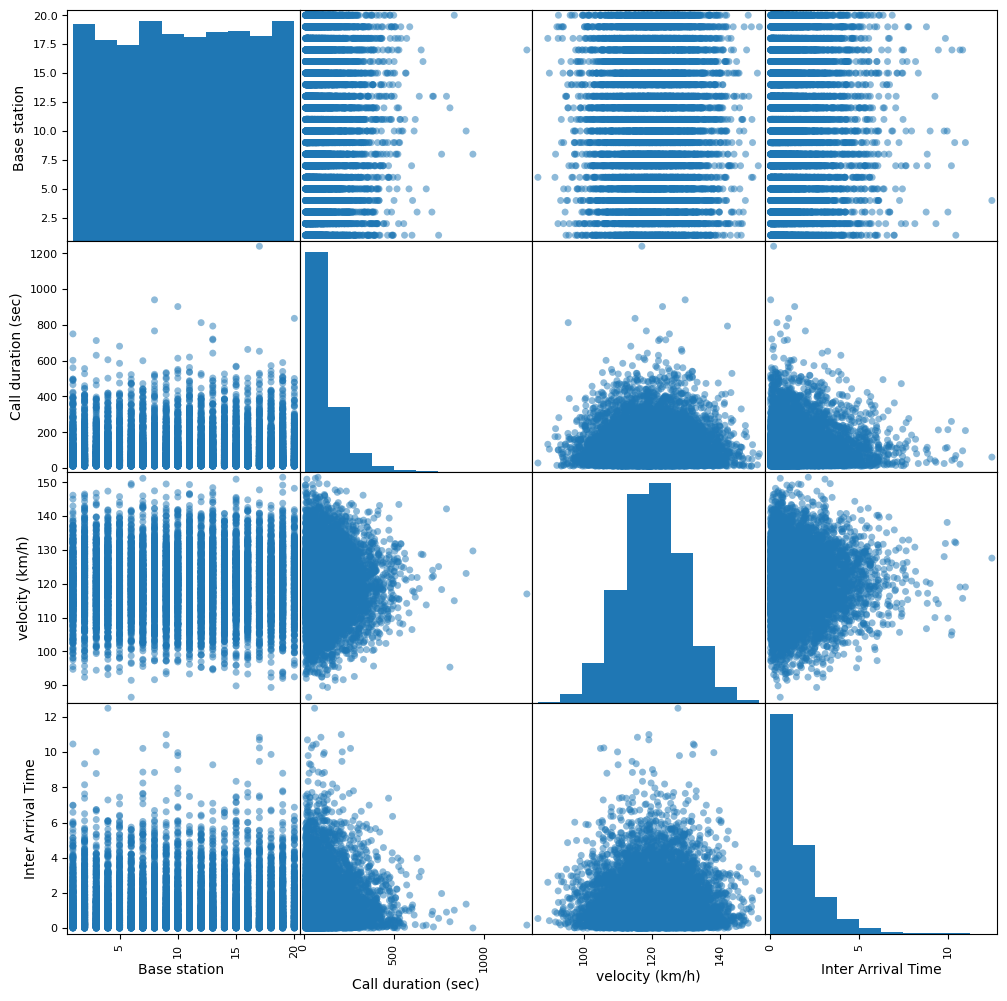

       Base station   Call duration (sec)  velocity (km/h)  Inter Arrival Time
count    10000.00000         10000.000000     10000.000000         9999.000000
mean        10.54220           109.835897       120.072095            1.369817
std          5.78662            99.138915         9.019056            1.343924
min          1.00000            10.004000        86.423000            0.000000
25%          6.00000            38.777750       113.892500            0.408000
50%         11.00000            79.937500       120.021500            0.962000
75%         16.00000           148.109500       126.188250            1.892000
max         20.00000          1239.836000       151.501000           12.499000


In [40]:
# Remove the first column (index 0) from the DataFrame
temp_df = df.drop(df.columns[[0, 1]], axis=1)

# Scatter plot to visualize the correlation between 'PCS' and 'PCS_1'
# Generate scatter plots for all pairs of columns in temp_df
pd.plotting.scatter_matrix(temp_df, figsize=(12, 12), diagonal='hist', alpha=0.5, s=len(temp_df) **0.5)
plt.show()

# Print basic statistics for each column in temp_df
print(temp_df.describe())

## Step 1: Data Independence
From the Correlation and scatter plots, we can observe that the variables are independent of each other.

## Step 2: Family of distributions
From the histograms, we can observe:
- Base Station is uniformly distributed
- Positiona in Base Station is uniformly distributed *
- Call Duration is exponentially distributed
- Velocity is normally distributed
- Inter Arrival Time is exponentially distributed

\* From the assignment, Assumtion (c) - "The position of the car initiating a call in a cell is uniformly distributed along the section of the highway covered by the base station."

### Call Duration Analysis
#### Step 3: Estimation of the parameters of a probability distribution (Call Duration)

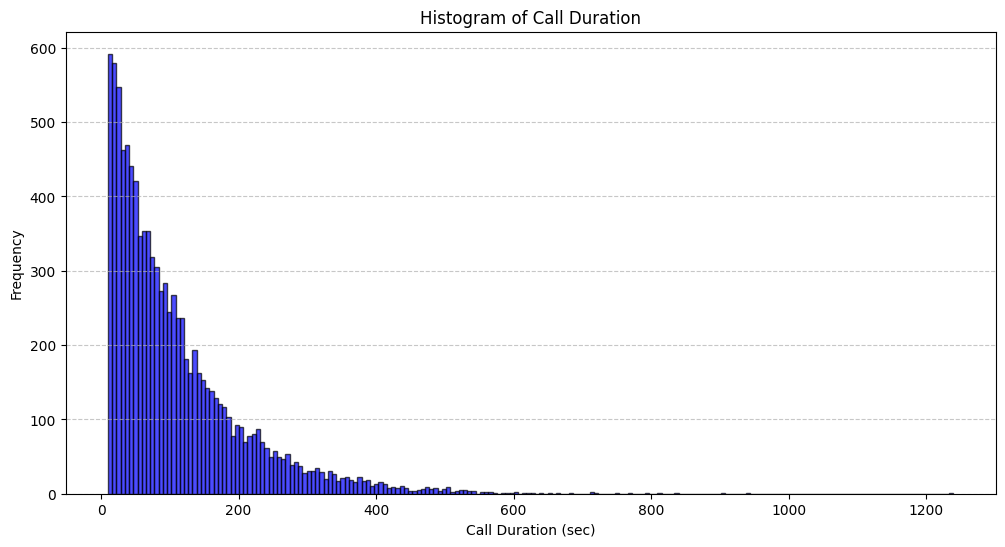

Bottom 10 Call durations:
5157    10.004
5610    10.033
1783    10.045
8638    10.047
4642    10.048
3723    10.049
400     10.064
6106    10.073
3041    10.079
1654    10.081
Name: Call duration (sec), dtype: float64


In [61]:
plt.figure(figsize=(12, 6))  # Set the figure size to make the plot wider
df['Call duration (sec)'].plot(kind='hist', bins=200, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Call Duration')
plt.xlabel('Call Duration (sec)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Bottom 10 Call durations:")
print(temp_df['Call duration (sec)'].nsmallest(10))

We would use a shifted exponential distribution to model the call duration.

From slide deck 4, input modeling, slide 21, we would use

_Shifted Exponential distribution_ $X \sim \text{ShiftedExponential}(\lambda, x_0)$

Where $\lambda$ is the rate parameter and $x_0$ is the shift parameter.

PDF:
$$f(x) = \begin{cases} \lambda e^{-\lambda (x - x_0)} & x \geq x_0 \\ 0 & x < x_0 \end{cases}$$

Maximum Likelihood Estimation (MLE) for the parameters $\lambda$ and $x_0$ is given by:
$$\hat{\lambda} = \frac{1}{\bar{x} - x_0}$$
$$\hat{x_0} = \min(x)$$

Where $\bar{x}$ is the sample mean and $x$ is the sample data.

\* for simplicity, we would assume $x_0 = \min(x)$ , $x_0 = 10.000$ as:
- $ 10.000 \approx \min(x) = 10.004$
- $x_0 \leq \min(x)$




In [62]:
sample_mean = df['Call duration (sec)'].mean()
lambda_had = 1/sample_mean
print("Sample mean:", sample_mean)
print("Lambda (1/sample mean):", lambda_had)

Sample mean: 109.8358973
Lambda (1/sample mean): 0.009104491560429032


From this, we will selected
$$ \hat{\lambda} = 0.009104491560429032$$
$$\hat{x_0} = 10.000$$

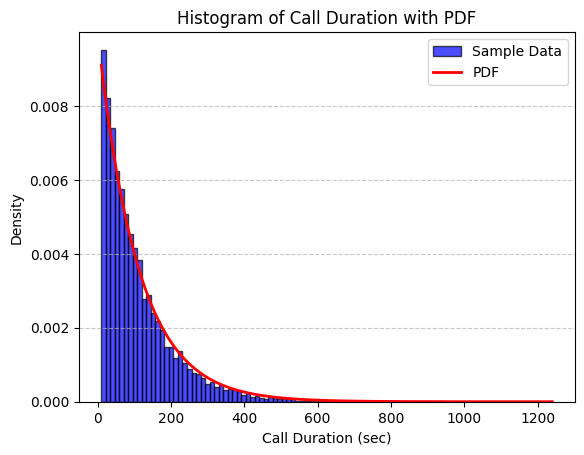

In [66]:
x0_hat = 10 # Lower bound of the first bin
lambda_hat = 0.009104491560429032 # Estimated parameter of the shifted exponential distribution

plt.hist(df["Call duration (sec)"], bins=100, alpha=0.7, color='blue', edgecolor='black', density=True, label='Sample Data')
x = np.linspace(df["Call duration (sec)"].min(), df["Call duration (sec)"].max(), 1000)
pdf = lambda_hat * np.exp(-lambda_hat * (x - x0_hat))
plt.plot(x, pdf, color='red', label='PDF', linewidth=2)
plt.title('Histogram of Call Duration with PDF')
plt.xlabel('Call Duration (sec)')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#### Step 4: Statistical goodness-of-fit test (Call Duration)
We would use chi-square test at 5% significance level to test the goodness of fit of the shifted exponential distribution.

We are using Chi-square test because there is a large sample size.

$H_0$: X conforms to f(x)
$H_1$: X does not conform to f(x)

since $n = 10000$, we would use $k = \sqrt{n} = 100$ bins.  
$$p_j = \frac{1}{k} = 0.01$$

In [ ]:
# #### Step 4: Statistical goodness-of-fit test (Call Duration)
# We would use chi-square test at 5% significance level to test the goodness of fit of the shifted exponential distribution.

# $H_0$: X conforms to f(x)
# $H_1$: X does not conform to f(x)

# since $n = 10000$, we would use $k = \sqrt{n} = 100$ bins.  
# $$p_j = \frac{1}{k} = 0.01$$
# $$n \cdot p_j = 10000 * 0.01 = 100 \geq 5$$

n = 10000  # Sample size
k = math.sqrt(n)  # Number of bins
p_j = 1/k # Probability of each bin
n_pj = n * p_j  # Expected frequency in each bin

x0_hat = 10 # Lower bound of the first bin
lambda_hat = 0.009104491560429032 # Estimated parameter of the shifted exponential distribution

bins_edges = x0_hat + stats.expon.ppf(np.linspace(0, 1, int(k)+1), scale=1/lambda_hat)


bins = pd.cut(temp_df['Call duration (sec)'], bins=bins_edges, right=False)
observed_counts = bins.value_counts().sort_index()
bin_df = pd.DataFrame(observed_counts).reset_index()
bin_df.rename(columns={'index': 'Class Interval', 'Call duration (sec)': 'n_j'}, inplace=True)
bin_df['n_pj'] = n_pj  # Expected frequency in each bin
bin_df["(Nj-npj)^2/npj"] = ((bin_df["n_j"] - n_pj) ** 2) / n_pj

print(bin_df)

chi_stat  = bin_df["(Nj-npj)^2/npj"].sum()
print("Chi-square statistic:", chi_stat )

degrees_of_freedom = k - 2 - 1  # Number of bins - number of parameters estimated - 1
print("Degrees of freedom:", degrees_of_freedom)

p_value = 1 - stats.chi2.cdf(chi_stat, degrees_of_freedom)

alpha = 0.05  # Significance level
reject_null = p_value < alpha

print(f"P-value: {p_value}")
print(f"Null hypothesis is {'rejected' if reject_null else 'not rejected'} at the {alpha} significance level.")



        Class Interval  n_j   n_pj  (Nj-npj)^2/npj
0       [10.0, 11.104)   95  100.0            0.25
1     [11.104, 12.219)  104  100.0            0.16
2     [12.219, 13.346)  116  100.0            2.56
3     [13.346, 14.484)  106  100.0            0.36
4     [14.484, 15.634)  117  100.0            2.89
..                 ...  ...    ...             ...
95  [339.039, 363.548)   87  100.0            1.69
96  [363.548, 395.146)   88  100.0            1.44
97  [395.146, 439.681)   77  100.0            5.29
98  [439.681, 515.813)   73  100.0            7.29
99      [515.813, inf)   49  100.0           26.01

[100 rows x 4 columns]
Chi-square statistic: 175.61999999999995
Degrees of freedom: 97.0
P-value: 1.8092968252503283e-06
Null hypothesis is rejected at the 0.05 significance level.
